<a href="https://colab.research.google.com/github/Ali-Sab/aps360_project/blob/main/Copy_of_APS360_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import numpy as np
import time
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt # for plotting
import torch.optim as optim
import requests
torch.manual_seed(50)

In [7]:
# import audio libraries
import os
from os import listdir
from os.path import join
from scipy.io import wavfile
import IPython.display as ipd

import librosa
from librosa.feature import melspectrogram
from librosa import power_to_db
from librosa.effects import trim

In [8]:
#Plot size
plt.rcParams['figure.figsize'] = [12, 8]

In [9]:
#Download team data from Google Drive
if(not os.path.exists("./team_data.zip")):
    team_data_url = "https://drive.google.com/uc?export=download&id=1eycnGtDVzqW57EUBEQmJDPz2F1Dqgqdc"

    resp = requests.get(team_data_url, stream=True)

    with open("./team_data.zip", 'wb') as fd:
        for chunk in resp.iter_content(chunk_size=128):
            fd.write(chunk)

In [10]:
#Download Kaggle data from Google Drive
if(not os.path.exists("./KaggleFSDD.zip")):
    kaggle_data_url = "https://drive.google.com/uc?export=download&id=1Uoy-XzAqE12FIPdqf9adFz7dfTcjDI9N"

    resp = requests.get(kaggle_data_url, stream=True)

    with open("./KaggleFSDD.zip", 'wb') as fd:
        for chunk in resp.iter_content(chunk_size=128):
            fd.write(chunk)

In [ ]:
if(not os.path.exists("./team_recordings")):
    !unzip './team_data.zip' -d './team_recordings'

In [ ]:
if(not os.path.exists("./kaggle_recordings")):
    !unzip './KaggleFSDD.zip' -d './kaggle_recordings'

In [13]:
# load audio files
def load_files(files, X, y):
    for file in files:
        label = int(file.split("_")[0])
        rate, data = wavfile.read(join(dir, file))
        X.append(data.astype(np.float32))
        y.append(label)
    return rate

X = []
y = []

# load team recordings
dir = './team_recordings/all'
files = listdir(dir)
rate1 = load_files(files, X, y)

# load Kaggle recordings
dir = './kaggle_recordings/recordings'
files = listdir(dir)
rate2 = load_files(files, X, y)

rate = min(rate1, rate2)

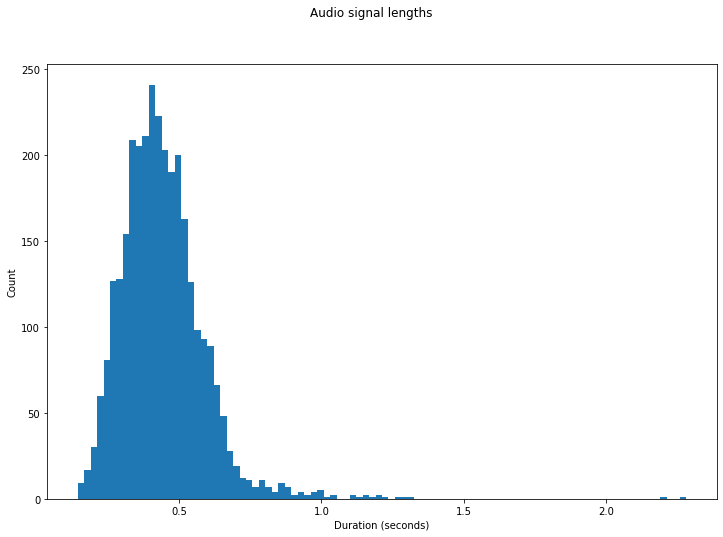

0.6635624999999996


In [14]:
# check distribution of length of audio clips

def show_length_distribution(signals, rate=8000):
    sample_times = [len(x)/rate for x in signals]

    fig = plt.figure()
    plt.hist(x=sample_times, bins = 'fd')
    fig.suptitle('Audio signal lengths')
    plt.xlabel('Duration (seconds)')
    plt.ylabel('Count')

    plt.show()
    return sample_times

lengths = show_length_distribution(X)
print(np.percentile(lengths, 95))

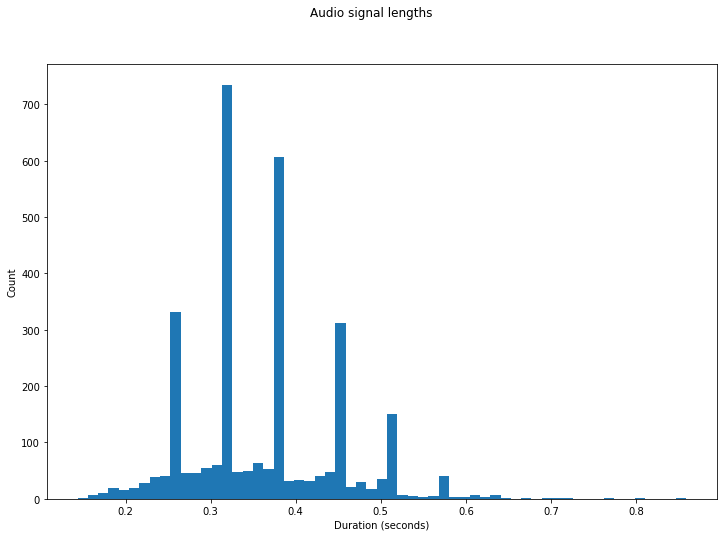

In [15]:
def remove_silence(sample, sr= 8000, top_db = 10):
    """This function removes trailing and leading silence periods of audio signals.
    """
    y = np.array(sample, dtype = np.float64)
    # Trim the beginning and ending silence
    yt, _ = trim(y, top_db= top_db)
    return yt
X_tr = [remove_silence(x) for x in X]

show_length_distribution(X_tr);

In [16]:
# pad all clips to same length

N = int(rate * 0.7)
X_uniform = []
for x in X_tr:
    if len(x) < N:
        X_uniform.append(np.pad(x, (0, N - len(x)), constant_values = (0, 0)))
    else:
        X_uniform.append(x[:N])

Digit: 7


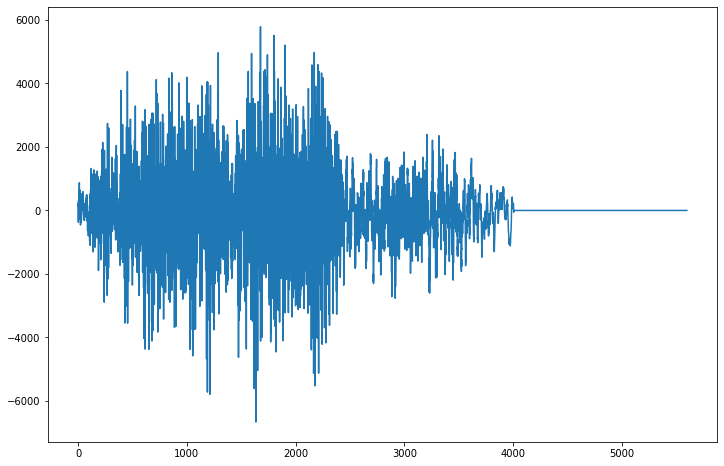

In [17]:
# playback some audio clips

index = 50
print("Digit: {}".format(y[index]))
plt.plot(X_uniform[index])
plt.show()
ipd.Audio(X_uniform[index], rate=8000)

(128, 11)


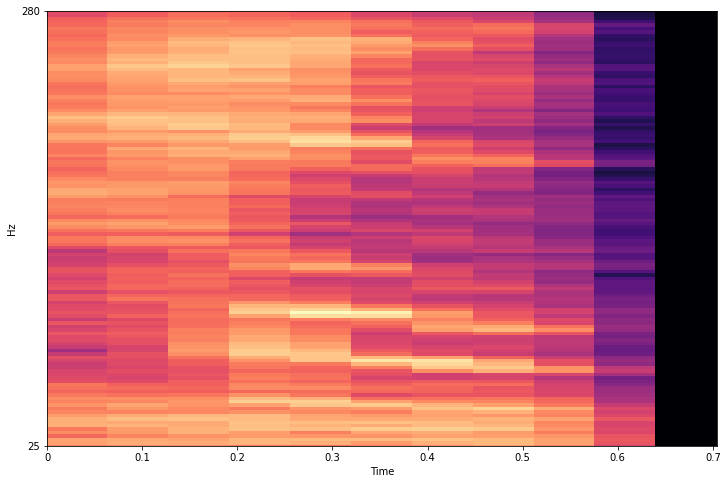

In [19]:
from librosa import display
#S = librosa.util.normalize(X_uniform[4])      makes no difference to normalize...
S = librosa.feature.melspectrogram(y=X_uniform[50], sr=8000)
print(S.shape)
#print(S[127])

display.specshow(librosa.power_to_db(S, ref=np.max), x_axis='time', y_axis='mel', fmin=25, fmax=280, sr=8000)

# Need to transpose first to get n_mel/timestep format
S = S.transpose()

#print(S[0])

#from scipy import signal
#frequencies, times, spectrogram = signal.spectrogram(X_uniform[4], 8000)
#plt.pcolormesh(times, frequencies, spectrogram)
#plt.imshow(spectrogram)
#plt.ylabel('Frequency [Hz]')
#plt.xlabel('Time [sec]')

#plt.show()
#for x in X_uniform[0]:
#   print(x)

In [20]:
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# Form the training, validation, and test sets
def get_data_sets(data, labels, training_percentage=0.7, use_mel=False):
    # subtraction is necessary below because we are using integers and do not want any data to be unused because of rounding down the integers
    train_len = int(len(data)*training_percentage)
    val_len = int(len(data)*(1-training_percentage)/2)
    test_len = len(data) - train_len - val_len

    if(use_mel):
        # Get melspectrograms of each sample
        mel_list = []
        for i in range(len(data)):
            S = librosa.feature.melspectrogram(y=data[i], sr=8000)
            S = np.kron(S, np.ones((1, 11)))
            S = S.flatten()
            mel_list.append(S)
        x_train, x_val, y_train, y_val = sklearn.model_selection.train_test_split(mel_list, labels, test_size=val_len, random_state=1)
    else:
        x_train, x_val, y_train, y_val = sklearn.model_selection.train_test_split(data, labels, test_size=val_len, random_state=1)

    x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(x_train, y_train, test_size=test_len, random_state=1)

    return x_train, y_train, x_val, y_val, x_test, y_test

# Calc
def get_accuracy(classifier, x_data, y_data):
    pred = rfc.predict(x_data)
    correct = 0
    total = len(pred)
    for i in range(len(pred)):
        correct += pred[i] == y_data[i]

    return correct/total

def get_accuracy_by_class(classifier, x_data, y_data):
    pred = rfc.predict(x_data)
    classes = max(y_data) + 1
    correct = [0]*classes
    total = [0]*classes
    for i in range(len(pred)):
        correct[y_data[i]] += pred[i] == y_data[i]
        total[y_data[i]] += 1
    acc = [x / y for x, y in zip(correct, total)]

    return acc

In [21]:
#For baseline model, will need to implement random forest classifier
#Will use the following links as guides: (moreso the second link)
#https://medium.com/@pratyush.sinha/training-random-forest-by-back-propagation-for-fun-pytorch-part-1-a54674355aa7
#https://medium.com/@hjhuney/implementing-a-random-forest-classification-model-in-python-583891c99652

rfc = RandomForestClassifier(random_state=10, n_estimators=100, max_features=100, warm_start=True, min_samples_leaf=10, verbose=True, n_jobs=-1)
x_train, y_train, x_val, y_val, x_test, y_test = get_data_sets(X_uniform, y, use_mel=True)
rfc.fit(x_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.8s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=100,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=10,
                       verbose=True, warm_start=True)

In [22]:
print("Validation Accuracy: {}%".format(100*get_accuracy(rfc, x_val, y_val)))
print("Test Accuracy: {}%".format(100*get_accuracy(rfc, x_test, y_test)))

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


Validation Accuracy: 89.1025641025641%
Test Accuracy: 90.38461538461539%


In [23]:
val_acc_class = get_accuracy_by_class(rfc, x_val, y_val)
val_acc_class[:] = [x * 100 for x in val_acc_class]
test_acc_class = get_accuracy_by_class(rfc, x_test, y_test)
test_acc_class[:] = [x * 100 for x in test_acc_class]

print("Validation accuracy of each class from 0 to 9:")
print('\n'.join('{}: {}%'.format(*k) for k in enumerate(val_acc_class)))
print("Test accuracy of each class from 0 to 9:")
print('\n'.join('{}: {}%'.format(*k) for k in enumerate(test_acc_class)))

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.0s finished


Validation accuracy of each class from 0 to 9:
0: 97.87234042553192%
1: 86.27450980392157%
2: 97.36842105263158%
3: 76.59574468085107%
4: 96.29629629629629%
5: 90.0%
6: 82.97872340425532%
7: 80.3921568627451%
8: 100.0%
9: 87.2340425531915%
Test accuracy of each class from 0 to 9:
0: 95.55555555555556%
1: 91.48936170212765%
2: 97.91666666666666%
3: 75.0%
4: 100.0%
5: 91.30434782608695%
6: 86.95652173913044%
7: 93.33333333333333%
8: 97.5609756097561%
9: 79.59183673469387%


# Deep Learning Models

In [24]:
class DigitRecognitionNet1(nn.Module):
    def __init__(self):
        super(DigitRecognitionNet1, self).__init__()
        self.name = 'DigitRecognitionNet1'
        self.conv1 = nn.Conv2d(1, 3, 4)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(3 * 62 * 59, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 3 * 62 * 59)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        #x = x.squeeze(1) # Flatten to [batch_size]
        return x
    
class DigitRecognitionNet2(nn.Module):
    def __init__(self):
        super(DigitRecognitionNet2, self).__init__()
        self.name = 'DigitRecognitionNet2'
        self.conv1 = nn.Conv2d(1, 5, 2)
        self.conv2 = nn.Conv2d(5, 25, 2)
        self.conv3 = nn.Conv2d(25, 50, 3)
        self.fc1 = nn.Linear(50 * 124 * 117, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 50 * 124 * 117)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        #x = x.squeeze(1) # Flatten to [batch_size]
        return x
    
class DigitRecognitionNet3(nn.Module):
    def __init__(self):
        super(DigitRecognitionNet3, self).__init__()
        self.name = 'DigitRecognitionNet3'
        self.conv1 = nn.Conv2d(1, 5, 3)
        self.conv2 = nn.Conv2d(5, 25, 3)
        self.fc1 = nn.Linear(25 * 124 * 117, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1, 25 * 124 * 117)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        #x = x.squeeze(1) # Flatten to [batch_size]
        return x
    
class DigitRecognitionNet4(nn.Module):
    def __init__(self):
        super(DigitRecognitionNet4, self).__init__()
        self.name = 'DigitRecognitionNet4'
        self.fc1 = nn.Linear(128 * 121, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = x.view(-1, 128 * 121)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        #x = x.squeeze(1) # Flatten to [batch_size]
        return x

In [26]:
# After receiving necessary tensors
from torch.utils.data import DataLoader

def get_data_loader(data, batch_size, training_percentage=0.7):
    # subtraction is necessary below because we are using integers and do not want any data to be unused because of rounding down the integers
    train_len = int(len(data)*training_percentage)
    val_len = int(len(data)*(1-training_percentage)/2)
    test_len = len(data) - train_len - val_len
    train_set, val_set, test_set = torch.utils.data.random_split(data, [train_len, val_len, test_len])

    train_loader = DataLoader(train_set, batch_size, shuffle=True)
    if val_len > 0:
        val_loader = DataLoader(val_set, batch_size, shuffle=True)
    else:
        val_loader = []
    if test_len > 0:
        test_loader = DataLoader(test_set, batch_size, shuffle=True)
    else:
        test_loader = []

    return train_loader, val_loader, test_loader

batch_size = 64

In [38]:
def train_net(net, data, batch_size=64, learning_rate=1e-3, num_epochs=30, training_percentage=0.7, weight_decay=0, save_checkpoint=True):
    ########################################################################
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader, val_loader, test_loader = get_data_loader(
            data, batch_size, training_percentage)
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=weight_decay)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_correct = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            net.train()
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
                inputs = inputs.cuda()
                labels = labels.cuda()
            #############################################
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            #print(inputs)
            #print(outputs)
            #print(labels)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            pred = outputs.max(1, keepdim=True)[1]
            total_train_correct += pred.eq(labels.view_as(pred)).sum().item()
            total_epoch += inputs.shape[0]
            total_train_loss += loss.item()

        train_err[epoch] = float(total_epoch - total_train_correct) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        if(epoch == num_epochs-1):
          final_train_accur = 1-val_err[epoch]
          final_valid_accur = 1-train_err[epoch]
          return final_train_accur, final_valid_accur
        #print(("Epoch {}: Train err: {}, Train loss: {} |"+
               #"Validation err: {}, Validation loss: {}").format(
                   #epoch + 1,
                   #train_err[epoch],
                   #train_loss[epoch],
                   #val_err[epoch],
                   #val_loss[epoch]))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
        if save_checkpoint:
          torch.save(net.state_dict(), model_path)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total time elapsed: {:.2f} seconds".format(elapsed_time))
    # Write the train/test loss/err into CSV file for plotting later
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_err.csv".format(model_path), train_err)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_err.csv".format(model_path), val_err)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

# Evaluating accuracy
def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

      Args:
          net: PyTorch neural network object
          loader: PyTorch data loader for the validation set
          criterion: The loss function
      Returns:
          err: A scalar for the avg classification error over the validation set
          loss: A scalar for the average loss function over the validation set
      """
    net.eval()
    total_loss = 0.0
    total_correct = 0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
            inputs = inputs.cuda()
            labels = labels.cuda()
        #############################################
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        pred = outputs.max(1, keepdim=True)[1]
        total_correct += pred.eq(labels.view_as(pred)).sum().item()
        total_epoch += inputs.shape[0]
        total_loss += loss.item()
    if total_epoch == 0:
        print("No data in loader")
        return 1,1
    err = float(total_epoch-total_correct) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name, batch_size, learning_rate, epoch)
    return path

    # Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

In [28]:
def scale_minmax(X, min=0.0, max=1.0):
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (max - min) + min
    print(X.min())
    print(X.max())
    return X_scaled

from torch.utils.data import TensorDataset

use_mel = True
X_final = []
if(use_mel):
    # Get melspectrograms of each sample
    for i in range(len(X_uniform)):
        S = librosa.feature.melspectrogram(y=X_uniform[i], sr=8000)
        S = np.kron(S, np.ones((1, 11)))
        X_final.append(S)
else:
    X_final = X_uniform
    
X_np = np.array(X_final)
print(X_np.max())
print(X_np.mean())
X_np = np.clip(X_np, 0, X_np.mean()*4)    # 1600 mels is 2000hz, which is the highest frequency we expect from a person
X_final = scale_minmax(X_np, 0, 1)
X_tensor = torch.Tensor(X_final)
y_tensor = torch.Tensor(y).long()

X_tensor = X_tensor.unsqueeze(1)
print(X_tensor.shape)
print(y_tensor.shape)
print(X_tensor[0])
print(y_tensor[0])

dataset = TensorDataset(X_tensor, y_tensor)
print(len(dataset))

1872188296608.9353
826489899.9212593
0.0
3305959599.685037
torch.Size([3120, 1, 128, 121])
torch.Size([3120])
tensor([[[1.8089e-04, 1.8089e-04, 1.8089e-04,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [8.0069e-04, 8.0069e-04, 8.0069e-04,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [4.5768e-03, 4.5768e-03, 4.5768e-03,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         ...,
         [1.1788e-05, 1.1788e-05, 1.1788e-05,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [2.1238e-05, 2.1238e-05, 2.1238e-05,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [1.7956e-05, 1.7956e-05, 1.7956e-05,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00]]])
tensor(1)
3120


In [ ]:
print(X_np.std())

663255124.323948


In [31]:
use_cuda = False

In [ ]:
net1 = DigitRecognitionNet1()
if use_cuda:
  net1 = net1.cuda()
best_trainning_accur = 0
best_valid_accur = 0
best_epoch_num = 0
best_batch_size = 0
final_train_accur = 0
final_valid_accur = 0
for epoch in range(100):
  for batch_size in range(100):
    if(epoch != 0 and batch_size != 0):
      final_train_accur, final_valid_accur = train_net(net1, dataset, batch_size=batch_size, learning_rate=1e-3, num_epochs=epoch, training_percentage=0.7, weight_decay=0, save_checkpoint=False)
      if(final_train_accur > best_trainning_accur or final_valid_accur > best_valid_accur):
        best_trainning_accur = final_train_accur
        best_valid_accur = final_valid_accur
        best_epoch_num = epoch
        best_batch_size = batch_size
        
print(best_trainning_accur, best_valid_accur, best_batch_size, best_epoch_num)

Epoch 1: Train err: 0.842948717948718, Train loss: 2.281028175354004 |Validation err: 0.655982905982906, Validation loss: 2.2258733808994293
Epoch 2: Train err: 0.6611721611721612, Train loss: 2.174064098085676 |Validation err: 0.5811965811965812, Validation loss: 2.0452838391065598
Epoch 3: Train err: 0.6002747252747253, Train loss: 1.9461219106401717 |Validation err: 0.5235042735042735, Validation loss: 1.7481819987297058
Epoch 4: Train err: 0.47023809523809523, Train loss: 1.608972430229187 |Validation err: 0.42094017094017094, Validation loss: 1.4252205938100815
Epoch 5: Train err: 0.40613553113553114, Train loss: 1.3274776220321656 |Validation err: 0.38461538461538464, Validation loss: 1.2015660107135773
Epoch 6: Train err: 0.3516483516483517, Train loss: 1.143950617313385 |Validation err: 0.344017094017094, Validation loss: 1.0741780176758766
Epoch 7: Train err: 0.3108974358974359, Train loss: 1.0390254599707467 |Validation err: 0.30982905982905984, Validation loss: 0.97257632762

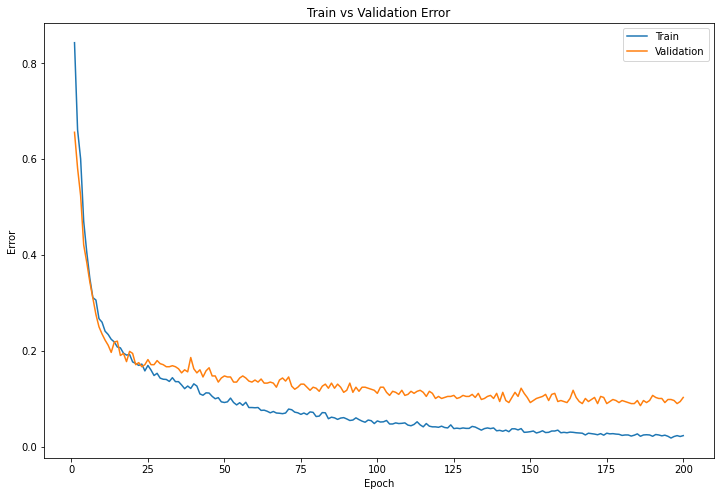

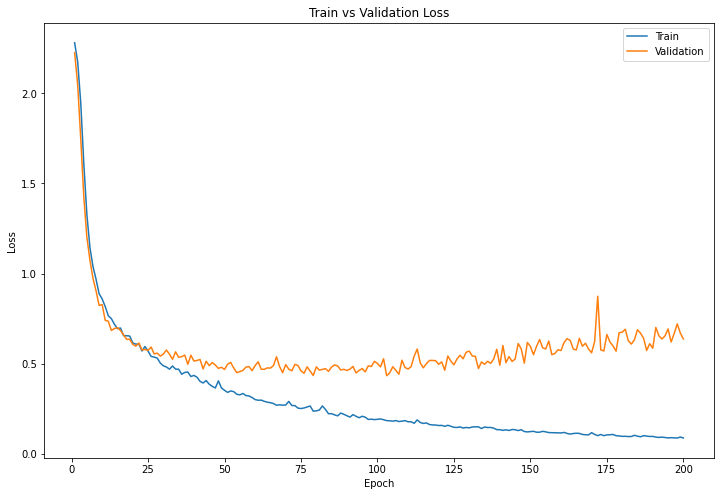

In [ ]:
net1 = DigitRecognitionNet1()
if use_cuda:
  net1 = net1.cuda()
train_net(net1, dataset, batch_size=64, learning_rate=1e-3, num_epochs=200, training_percentage=0.7, weight_decay=0, save_checkpoint=False)
plot_training_curve(get_model_name("DigitRecognitionNet1", 64, 1e-3, 199))

Epoch 1: Train err: 0.8695054945054945, Train loss: 2.294043357031686 |Validation err: 0.782051282051282, Validation loss: 2.2756654918193817
Epoch 2: Train err: 0.8095238095238095, Train loss: 2.23217146056039 |Validation err: 0.8055555555555556, Validation loss: 2.177116334438324
Epoch 3: Train err: 0.7261904761904762, Train loss: 2.026925274303981 |Validation err: 0.6217948717948718, Validation loss: 1.7945136725902557
Epoch 4: Train err: 0.5077838827838828, Train loss: 1.4841758813176835 |Validation err: 0.4423076923076923, Validation loss: 1.1998636573553085
Epoch 5: Train err: 0.3411172161172161, Train loss: 0.9998553599630083 |Validation err: 0.3525641025641026, Validation loss: 0.9418438449501991
Epoch 6: Train err: 0.28983516483516486, Train loss: 0.854287348474775 |Validation err: 0.27136752136752135, Validation loss: 0.8260038569569588
Epoch 7: Train err: 0.23397435897435898, Train loss: 0.7560687354632787 |Validation err: 0.27136752136752135, Validation loss: 0.813585594296

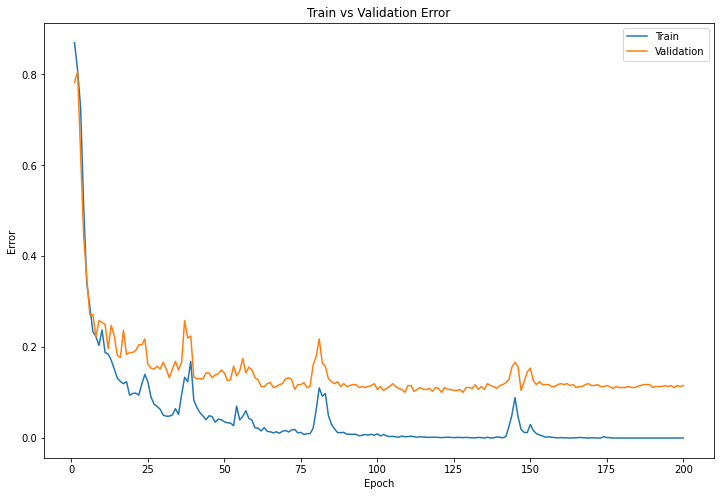

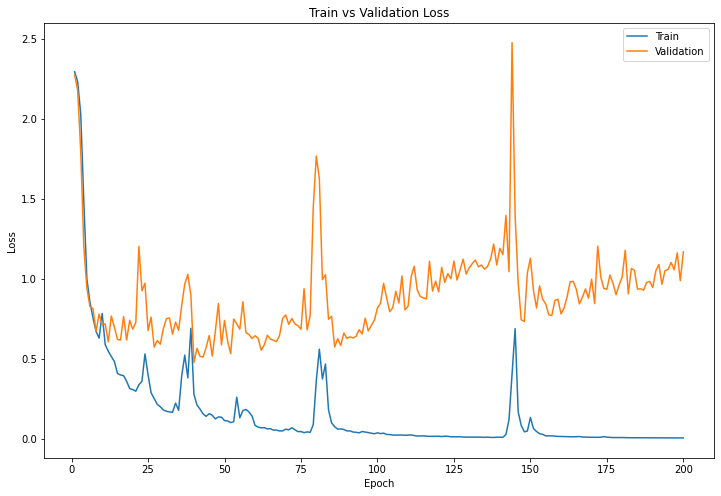

In [ ]:
net2 = DigitRecognitionNet2()
if use_cuda:
  net2 = net2.cuda()
train_net(net2, dataset, batch_size=64, learning_rate=1e-3, num_epochs=200, training_percentage=0.7, weight_decay=0, save_checkpoint=False)
plot_training_curve(get_model_name("DigitRecognitionNet2", 64, 1e-3, 199))

Epoch 1: Train err: 0.8914835164835165, Train loss: 2.3015638760157993 |Validation err: 0.9145299145299145, Validation loss: 2.2907507717609406
Epoch 2: Train err: 0.8855311355311355, Train loss: 2.2730086190359935 |Validation err: 0.8803418803418803, Validation loss: 2.253913015127182
Epoch 3: Train err: 0.8534798534798534, Train loss: 2.2141679968152728 |Validation err: 0.7991452991452992, Validation loss: 2.1459846198558807
Epoch 4: Train err: 0.6836080586080586, Train loss: 2.026368594169617 |Validation err: 0.5641025641025641, Validation loss: 1.797734871506691
Epoch 5: Train err: 0.5265567765567766, Train loss: 1.5614285605294365 |Validation err: 0.4423076923076923, Validation loss: 1.2915476858615875
Epoch 6: Train err: 0.4116300366300366, Train loss: 1.149294069835118 |Validation err: 0.38675213675213677, Validation loss: 0.9923498034477234
Epoch 7: Train err: 0.3347069597069597, Train loss: 0.9495817167418343 |Validation err: 0.3525641025641026, Validation loss: 0.930644132196

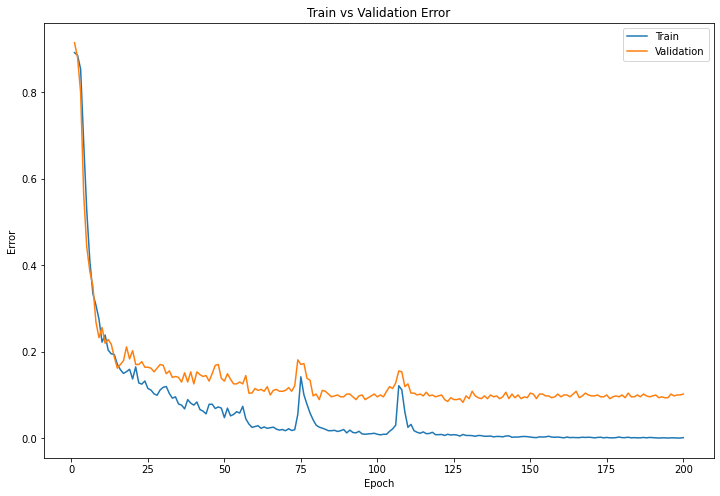

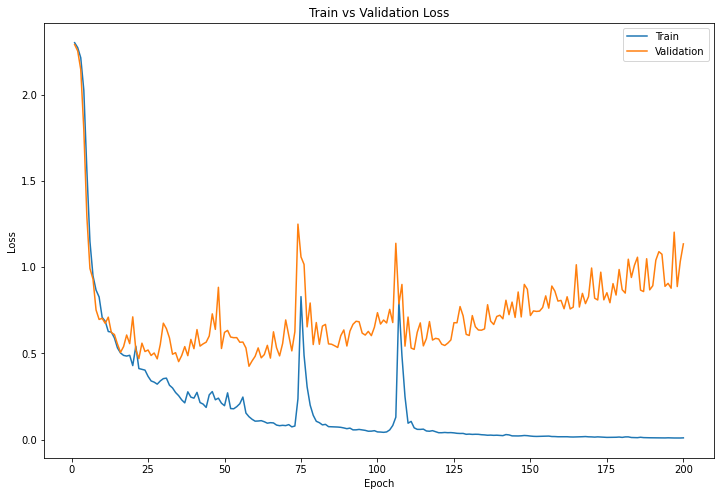

In [ ]:
net3 = DigitRecognitionNet3()
if use_cuda:
  net3 = net3.cuda()
train_net(net3, dataset, batch_size=64, learning_rate=1e-3, num_epochs=200, training_percentage=0.7, weight_decay=0, save_checkpoint=False)
plot_training_curve(get_model_name("DigitRecognitionNet3", 64, 1e-3, 199))

Epoch 1: Train err: 0.885989010989011, Train loss: 2.2919633524758476 |Validation err: 0.8717948717948718, Validation loss: 2.2905437648296356
Epoch 2: Train err: 0.825091575091575, Train loss: 2.2724019731794085 |Validation err: 0.8076923076923077, Validation loss: 2.2639819979667664
Epoch 3: Train err: 0.7843406593406593, Train loss: 2.250574105126517 |Validation err: 0.7628205128205128, Validation loss: 2.2429908215999603
Epoch 4: Train err: 0.73992673992674, Train loss: 2.2258564335959297 |Validation err: 0.7222222222222222, Validation loss: 2.21634504199028
Epoch 5: Train err: 0.7074175824175825, Train loss: 2.19784118107387 |Validation err: 0.7029914529914529, Validation loss: 2.1803090572357178
Epoch 6: Train err: 0.6813186813186813, Train loss: 2.168808514731271 |Validation err: 0.6752136752136753, Validation loss: 2.1602107286453247
Epoch 7: Train err: 0.6465201465201466, Train loss: 2.1425303731645857 |Validation err: 0.6495726495726496, Validation loss: 2.1339125633239746
Ep

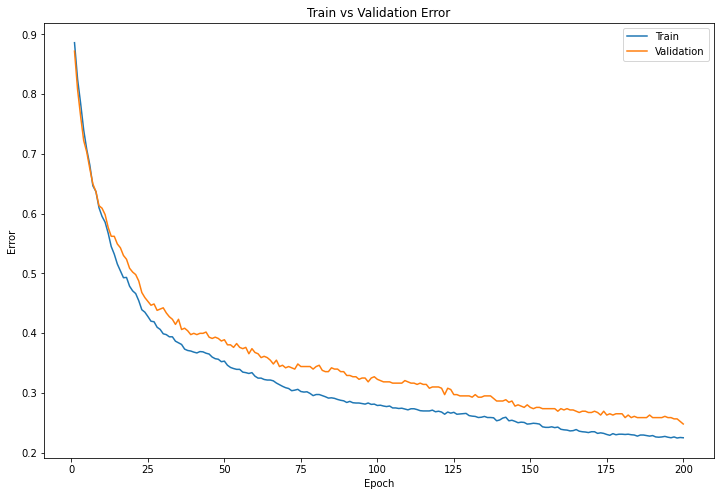

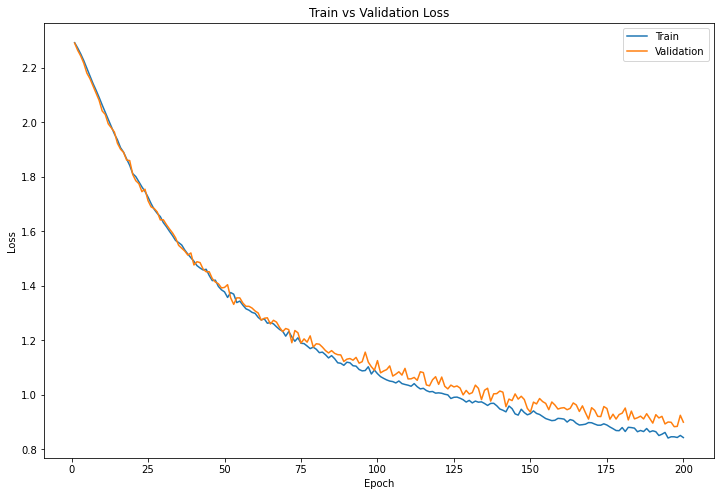

In [ ]:
net4 = DigitRecognitionNet4()
if use_cuda:
  net4 = net4.cuda()
train_net(net4, dataset, batch_size=64, learning_rate=1e-4, num_epochs=200, training_percentage=0.7, weight_decay=0, save_checkpoint=False)
plot_training_curve(get_model_name("DigitRecognitionNet4", 64, 1e-4, 199))